<a href="https://colab.research.google.com/github/pedromasb/tutorials/blob/main/notebooks/dimreduction_solarspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Dimensionality Reduction for Data Visualization With Python </center></h1>

Created by

**[Pedro Mas Buitrago](https://pedromasb.github.io/)**

**Last updated** by the author in March 2023

For the tutorial to work correctly, the user must upload [this data file](https://github.com/pedromasb/tutorials/tree/main/notebooks/data/dimreduction_solarspots) (Source: WDC-SILSO, Royal Observatory of Belgium, Brussels) in their own Google Colab session. To do this, click on the "Files" icon on the left side of the page, select the "Upload to session storage" option (first icon in the pop-up menu) and upload the files from the local directory.

---

In this brief tutorial, we will explore the use of dimensionality reduction focused on finding a good visualization of our global data context. We will build our use case around the data provided by the Sunspot Index and Long-term Solar Observations ([SILSO](https://www.sidc.be/silso/home)) on the monthly mean total sunspot number, which is obtained as asimple arithmetic mean of the daily value. You can see more info on how the daily total sunspot number (Wolf number) is derived [here](https://www.sidc.be/silso/infosndtot).





In [ ]:
! pip install -q umap-learn 

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
import plotly.express as px

## Data load and exploration

We load the data and create a column with the key Year-Month. We drop the values corresponding to the current year, since it will not be complete.

Then, we visualize the monthly data, where we can see very clearly that there is a cyclical trend in the total sunspot number, that is directly related to the solar magnetic activity.

In [4]:
col_names = ['year','month','mean_sunspot_number']
data = pd.read_csv('/content/SN_m_tot.csv',sep=';',usecols=[0,1,3],names=col_names,parse_dates=True)
data['year_month'] = data['year'].astype('str') + '-' + data['month'].astype('str')

today = datetime.date.today()
current_year = today.year

data = data[data['year'] < current_year]

data

,year,month,mean_sunspot_number,year_month
0,1749,1,96.7,1749-1
1,1749,2,104.3,1749-2
2,1749,3,116.7,1749-3
3,1749,4,92.8,1749-4
4,1749,5,141.7,1749-5
...,...,...,...,...
3283,2022,8,74.6,2022-8
3284,2022,9,96.0,2022-9
3285,2022,10,95.4,2022-10
3286,2022,11,77.6,2022-11


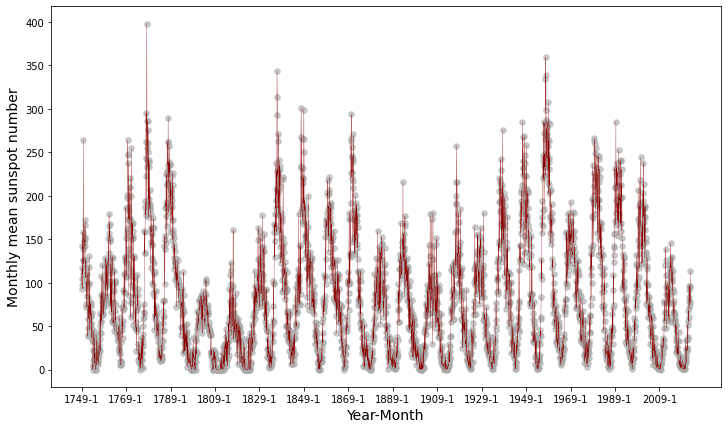

In [5]:
fig, ax = plt.subplots(figsize=(12,7))

ax.set_xlabel('Year-Month',fontsize=14)
ax.set_ylabel('Monthly mean sunspot number',fontsize=14)

ax.scatter(data.index,data['mean_sunspot_number'],s=30,color='darkgrey',alpha=0.6)
ax.plot(data['mean_sunspot_number'],lw=0.3,color='darkred')

ax.set_xticks(data.index[::240])
ax.set_xticklabels(data['year_month'][::240])

plt.show()

For our dimensionality reduction analysis, we  store each year's data in a separate array.

Also, we can aggregate the data by year and use the mean sunspot number for each year as an indicator of its solar activity.

In [6]:
aux_list = []

for y in data['year'].unique():
  year_values = data[data['year'] == y]['mean_sunspot_number'].values
  aux_list.append(year_values)

values_arr = np.stack(aux_list,axis=0)

In [7]:
year_group = data[['year','mean_sunspot_number']].groupby(by=['year']).mean().round()

year_group

,mean_sunspot_number
year,
1749,135.0
1750,139.0
1751,79.0
1752,80.0
1753,51.0
...,...
2018,7.0
2019,4.0
2020,9.0


If we visualize the aggregated data, the chart is much cleaner than before and we can now observe that the total number of sunspots varies with an approximately 11-year repetition. This is known as the solar cycle.

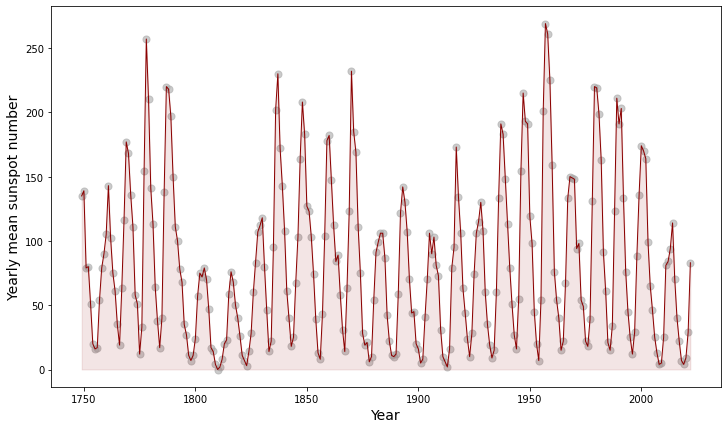

In [8]:
fig, ax = plt.subplots(figsize=(12,7))

ax.set_xlabel('Year',fontsize=14)
ax.set_ylabel('Yearly mean sunspot number',fontsize=14)

ax.scatter(year_group.index,year_group['mean_sunspot_number'],s=50,color='darkgrey',alpha=0.6)
ax.plot(year_group['mean_sunspot_number'],lw=1,color='darkred')
ax.fill_between(year_group.index,year_group['mean_sunspot_number'],lw=1,color='darkred',alpha=0.1)

plt.show()

## Data visualization by dimensionality reduction

Given that we have 12 variables for each year, how could we visualize the location of each year in the overall context of the data? One way to do this is to use dimensionality reduction techniques to project our data down to 2 dimensions. 

We explore two of the most popular algorithms: T-Distributed Stochastic Neighborhood Embedding (T-SNE) and Uniform Manifold Approximation and Projection (UMAP).

After dimension reduction, we use Plotly to create an insightful visualization that allows us to extract information quickly.

First of all, we standardize our data.

In [9]:
std_data = StandardScaler().fit_transform(values_arr)

#### T-SNE

More info about the agorithm [here](https://distill.pub/2016/misread-tsne/)

In [10]:
tsne = TSNE(random_state=42,n_components=2,verbose=0,perplexity=20,n_iter=1000)
model_tsne = tsne.fit_transform(std_data)

In [11]:
tsne_dict = {'tsne_comp1':model_tsne[:,0],'tsne_comp2':model_tsne[:,1],
             'Year':year_group.index.values,'Yearly mean sunspot number':year_group['mean_sunspot_number']}
tsne_df = pd.DataFrame(tsne_dict)

In [12]:
fig = px.scatter(tsne_df,x='tsne_comp1',y='tsne_comp2',template='plotly_white',
                 color='Yearly mean sunspot number',color_continuous_scale='sunset_r',
                 custom_data=['Year','Yearly mean sunspot number'],width=800, height=600)
fig.update_traces(marker=dict(size=8),
                  hovertemplate="<br>".join([
                      "Year: %{customdata[0]}",
                      "Yearly mean sunspot number: %{customdata[1]}"]))

fig.show()

#### UMAP

More info about the agorithm [here](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)

In [13]:
umap_alg = umap.UMAP(random_state=42,n_components=2,n_neighbors=20)
model_umap = umap_alg.fit_transform(std_data)

In [14]:
umap_dict = {'umap_comp1':model_umap[:,0],'umap_comp2':model_umap[:,1],
             'Year':year_group.index.values,'Yearly mean sunspot number':year_group['mean_sunspot_number']}
umap_df = pd.DataFrame(umap_dict)

In [15]:
fig = px.scatter(umap_df,x='umap_comp1',y='umap_comp2',template='plotly_white',
                 color='Yearly mean sunspot number',color_continuous_scale='sunset_r',
                 custom_data=['Year','Yearly mean sunspot number'],width=750, height=550)
fig.update_traces(marker=dict(size=8),
                  hovertemplate="<br>".join([
                      "Year: %{customdata[0]}",
                      "Yearly mean sunspot number: %{customdata[1]}"]))

fig.show()